# Check if FindingEmo images are annotated correctly

In [2]:
import polars as pl
import matplotlib.pyplot as plt
from PIL import Image
import os

pl.Config(fmt_str_lengths=1000, tbl_width_chars=1000)


Annotations and images have already been merged.  
`findingemo_process_annotations.py` does this.

In [3]:
df = pl.read_csv("../data/processed_annotations.csv")
df.glimpse()


Rows: 20147
Columns: 11
$ index       <i64> 0, 5, 6, 7, 8, 11, 12, 15, 17, 19
$ user        <str> '5fd97d5b40332e276ea58209', '5fd97d5b40332e276ea58209', '5985f6bdeef500000111db98', '5985f6bdeef500000111db98', '5fd97d5b40332e276ea58209', '5e9820b9c63c530008087a8c', '5fd97d5b40332e276ea58209', '5fd97d5b40332e276ea58209', '5fd97d5b40332e276ea58209', '5985f6bdeef500000111db98'
$ image_path  <str> '/Run_2/Loving toddlers sports/haiti-kids.jpg', '/Run_2/Frustrated forty-something office/team-work.jpg', '/Run_1/Violent youth festival/1042373588.jpg', '/Run_2/Remorseful toddlers court of law/dcfs-court-proceedings-legal-rep.jpg', '/Run_2/Shame elderly sports/3364887-46.jpg', '/Run_2/Joyful forty-something sports/Ann+Hobson+Pilot_01-1200x830.jpg', '/Run_2/Scared adolescents prison/15-hampton-roads-regional-jail-va.jpg', '/Run_2/Raging students party/Newly-elected-Nepal-Students-Union-President-Nainsign-Mahar.jpg', '/Run_1/Accepting children school/whitecoatceremony-2015.jpg', '/Run_2/Surprised

In [4]:
df["tags"].value_counts(sort=True)


shape: (47, 2)
┌───────────────────────────────────────────────────────┬───────┐
│ tags                                                  ┆ count │
│ ---                                                   ┆ ---   │
│ str                                                   ┆ u32   │
╞═══════════════════════════════════════════════════════╪═══════╡
│ Undefined                                             ┆ 18771 │
│ NoInteraction                                         ┆ 464   │
│ BadQualityPhoto                                       ┆ 354   │
│ Copyright                                             ┆ 218   │
│ Text                                                  ┆ 125   │
│ …                                                     ┆ …     │
│ BadQualityPhoto,Watermark,NoInteraction,NoPeople,Text ┆ 1     │
│ Copyright,NoPeople,Text                               ┆ 1     │
│ BadQualityPhoto,Copyright,Watermark,NA                ┆ 1     │
│ BadQualityPhoto,Watermark,Text                        ┆ 1     │
│ BadQualityPhoto,Watermark                             ┆ 1     │
└───────────────────────────────────────────────────────┴───────┘

In [5]:
df["emotion"].value_counts(sort=True)

shape: (24, 2)
┌──────────────┬───────┐
│ emotion      ┆ count │
│ ---          ┆ ---   │
│ str          ┆ u32   │
╞══════════════╪═══════╡
│ Joy          ┆ 2990  │
│ Interest     ┆ 2051  │
│ Serenity     ┆ 1539  │
│ Anticipation ┆ 1369  │
│ Vigilance    ┆ 1112  │
│ …            ┆ …     │
│ Terror       ┆ 276   │
│ Surprise     ┆ 246   │
│ Disgust      ┆ 207   │
│ Amazement    ┆ 163   │
│ Loathing     ┆ 145   │
└──────────────┴───────┘

In [6]:
df["age"].value_counts(sort=True)


shape: (34, 2)
┌─────────────────────────────────────┬───────┐
│ age                                 ┆ count │
│ ---                                 ┆ ---   │
│ str                                 ┆ u32   │
╞═════════════════════════════════════╪═══════╡
│ Adults                              ┆ 7645  │
│ Adults,Seniors                      ┆ 2104  │
│ Young Adults,Adults                 ┆ 2023  │
│ Young Adults                        ┆ 1691  │
│ Children,Adults                     ┆ 1274  │
│ …                                   ┆ …     │
│ Children,Youth,Seniors              ┆ 8     │
│ Youth,Young Adults,Seniors          ┆ 6     │
│ Children,Youth,Young Adults,Seniors ┆ 4     │
│ Young Adults,Seniors,Adults         ┆ 1     │
│ Seniors,Adults                      ┆ 1     │
└─────────────────────────────────────┴───────┘

Cols of potential interest:

In [7]:
df["dec_factors"].value_counts(sort=True)


shape: (58, 2)
┌──────────────────────────────────────────────────────────────────┬───────┐
│ dec_factors                                                      ┆ count │
│ ---                                                              ┆ ---   │
│ str                                                              ┆ u32   │
╞══════════════════════════════════════════════════════════════════╪═══════╡
│ BodyLanguage,FacialExpression                                    ┆ 3942  │
│ BodyLanguage,Context,FacialExpression                            ┆ 2011  │
│ FacialExpression                                                 ┆ 1968  │
│ BodyLanguage                                                     ┆ 1652  │
│ Context                                                          ┆ 1493  │
│ …                                                                ┆ …     │
│ Neutral,BodyLanguage,ConflictCtxtPerson,FacialExpression         ┆ 1     │
│ Neutral,BodyLanguage,ConflictCtxtPerson,Context,FacialExpression ┆ 1     │
│ Neutral,ConflictCtxtPerson,Context,Staging                       ┆ 1     │
│ Neutral,BodyLanguage,ConflictCtxtPerson,FacialExpression,Staging ┆ 1     │
│ Neutral,ConflictCtxtPerson,Context                               ┆ 1     │
└──────────────────────────────────────────────────────────────────┴───────┘

In FindingEmo, Ambiguity is an integer rating where the annotator indicates how ambiguous the overall emotional content of the whole photo felt—i.e., how hard it was to decide on the emotion. Higher = more ambiguous/harder to annotate.

In [18]:
(
    df.group_by("ambiguity")
    .agg(pl.len().alias("count"))
    .with_columns((pl.col("count") / pl.col("count").sum() * 100).alias("percentage"))
    .sort("percentage", descending=True)
)

shape: (7, 3)
┌───────────┬───────┬────────────┐
│ ambiguity ┆ count ┆ percentage │
│ ---       ┆ ---   ┆ ---        │
│ i64       ┆ u32   ┆ f64        │
╞═══════════╪═══════╪════════════╡
│ 1         ┆ 5009  ┆ 24.862262  │
│ 0         ┆ 4749  ┆ 23.571748  │
│ 2         ┆ 3705  ┆ 18.389835  │
│ 3         ┆ 2920  ┆ 14.493473  │
│ 4         ┆ 1929  ┆ 9.574626   │
│ 5         ┆ 1201  ┆ 5.961185   │
│ 6         ┆ 634   ┆ 3.146871   │
└───────────┴───────┴────────────┘

In [9]:
df.select("age", "valence", "arousal", "emotion", "dec_factors", "ambiguity").describe()


shape: (9, 7)
┌────────────┬────────────────────────────┬──────────┬──────────┬────────────┬──────────────┬───────────┐
│ statistic  ┆ age                        ┆ valence  ┆ arousal  ┆ emotion    ┆ dec_factors  ┆ ambiguity │
│ ---        ┆ ---                        ┆ ---      ┆ ---      ┆ ---        ┆ ---          ┆ ---       │
│ str        ┆ str                        ┆ f64      ┆ f64      ┆ str        ┆ str          ┆ f64       │
╞════════════╪════════════════════════════╪══════════╪══════════╪════════════╪══════════════╪═══════════╡
│ count      ┆ 20147                      ┆ 20147.0  ┆ 20147.0  ┆ 20147      ┆ 20147        ┆ 20147.0   │
│ null_count ┆ 0                          ┆ 0.0      ┆ 0.0      ┆ 0          ┆ 0            ┆ 0.0       │
│ mean       ┆ null                       ┆ 0.33747  ┆ 2.913337 ┆ null       ┆ null         ┆ 1.92108   │
│ std        ┆ null                       ┆ 1.795935 ┆ 1.63891  ┆ null       ┆ null         ┆ 1.659315  │
│ min        ┆ Adults                     ┆ -3.0     ┆ 0.0      ┆ Acceptance ┆ BodyLanguage ┆ 0.0       │
│ 25%        ┆ null                       ┆ -1.0     ┆ 2.0      ┆ null       ┆ null         ┆ 1.0       │
│ 50%        ┆ null                       ┆ 1.0      ┆ 3.0      ┆ null       ┆ null         ┆ 2.0       │
│ 75%        ┆ null                       ┆ 2.0      ┆ 4.0      ┆ null       ┆ null         ┆ 3.0       │
│ max        ┆ Youth,Young Adults,Seniors ┆ 3.0      ┆ 6.0      ┆ Vigilance  ┆ Undefined    ┆ 6.0       │
└────────────┴────────────────────────────┴──────────┴──────────┴────────────┴──────────────┴───────────┘

For valence, it goes from -3 to 3. For arousal, it goes from 0 to 6.

That’s not a mistake—it’s by design. In their dataset docs they explicitly state: “valence (named ‘Negative/Positive’ in the interface) integer scale from −3 to +3; arousal (named ‘Intensity’) integer scale from 0 to 6.”   
[Link](https://gitlab.com/EAVISE/lme/findingemo/-/raw/main/datasheet/datasheet.md). 

They also note that they renamed arousal to “Intensity” to avoid confusion and potential sexual connotation for crowd annotators, and that both dimensions were collected as integers rather than continuous sliders.   
[Link](https://ar5iv.labs.arxiv.org/html/2402.01355v2)

Why different anchors?  
Valence is bipolar in the circumplex model (negative ↔ positive), so a symmetric scale with a natural midpoint (0) makes sense for annotators and for modeling. 

Arousal is commonly conceptualized as low→high activation, not negative↔positive. Many psychological depictions literally label arousal from zero arousal up to high arousal. Using 0…6 matches that mental model and avoids the odd notion of “negative activation.”   

In [11]:
df["emotion"].value_counts(sort=True)

shape: (24, 2)
┌──────────────┬───────┐
│ emotion      ┆ count │
│ ---          ┆ ---   │
│ str          ┆ u32   │
╞══════════════╪═══════╡
│ Joy          ┆ 2990  │
│ Interest     ┆ 2051  │
│ Serenity     ┆ 1539  │
│ Anticipation ┆ 1369  │
│ Vigilance    ┆ 1112  │
│ …            ┆ …     │
│ Terror       ┆ 276   │
│ Surprise     ┆ 246   │
│ Disgust      ┆ 207   │
│ Amazement    ┆ 163   │
│ Loathing     ┆ 145   │
└──────────────┴───────┘

# Random Sample and check image against annotation

Skipping corrupted image: ../data/Run_2/Appalled adolescents playground/dreamstime-Playground-COMP.jpg


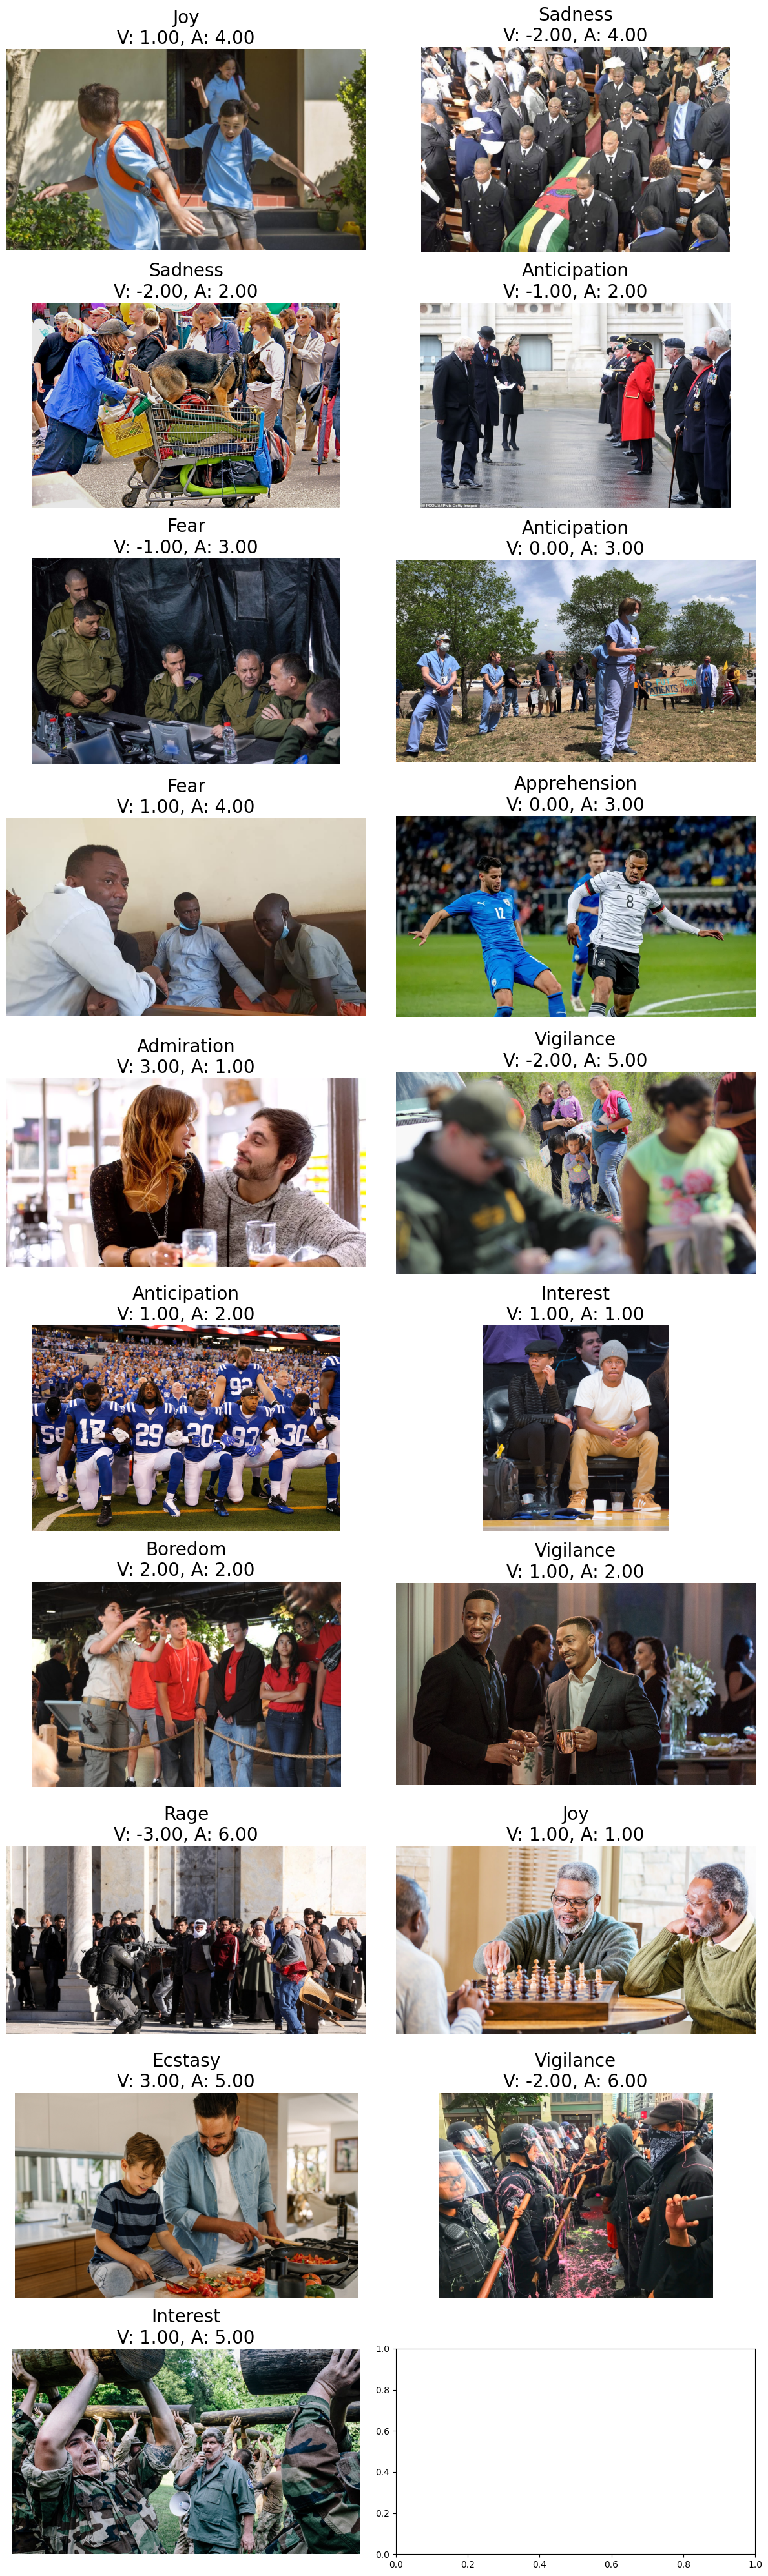

In [12]:
# Get sample of images to display
sample_df = df.select("image_path", "emotion", "valence", "arousal").sample(
    20
)  # Sample more to account for bad files

# Create a 10x2 grid with tall figure size
fig, axes = plt.subplots(
    10, 2, figsize=(12, 40)
)  # 10 rows, 2 columns, very tall figure
axes = axes.flatten()

displayed = 0
for row in sample_df.iter_rows(named=True):
    if displayed >= 20:  # Show 10 images
        break

    img_path = f"../data{row['image_path']}"
    if os.path.exists(img_path):
        try:
            img = Image.open(img_path)
            axes[displayed].imshow(img)
            axes[displayed].set_title(
                f"{row['emotion']}\nV: {row['valence']:.2f}, A: {row['arousal']:.2f}",
                fontsize=20,
            )
            axes[displayed].axis("off")
            displayed += 1
        except Exception as e:
            print(f"Skipping corrupted image: {img_path}")
            continue
    else:
        print(f"File not found: {img_path}")

plt.tight_layout()
plt.show()


# Corrupted images

There are some image files that are corrupted.

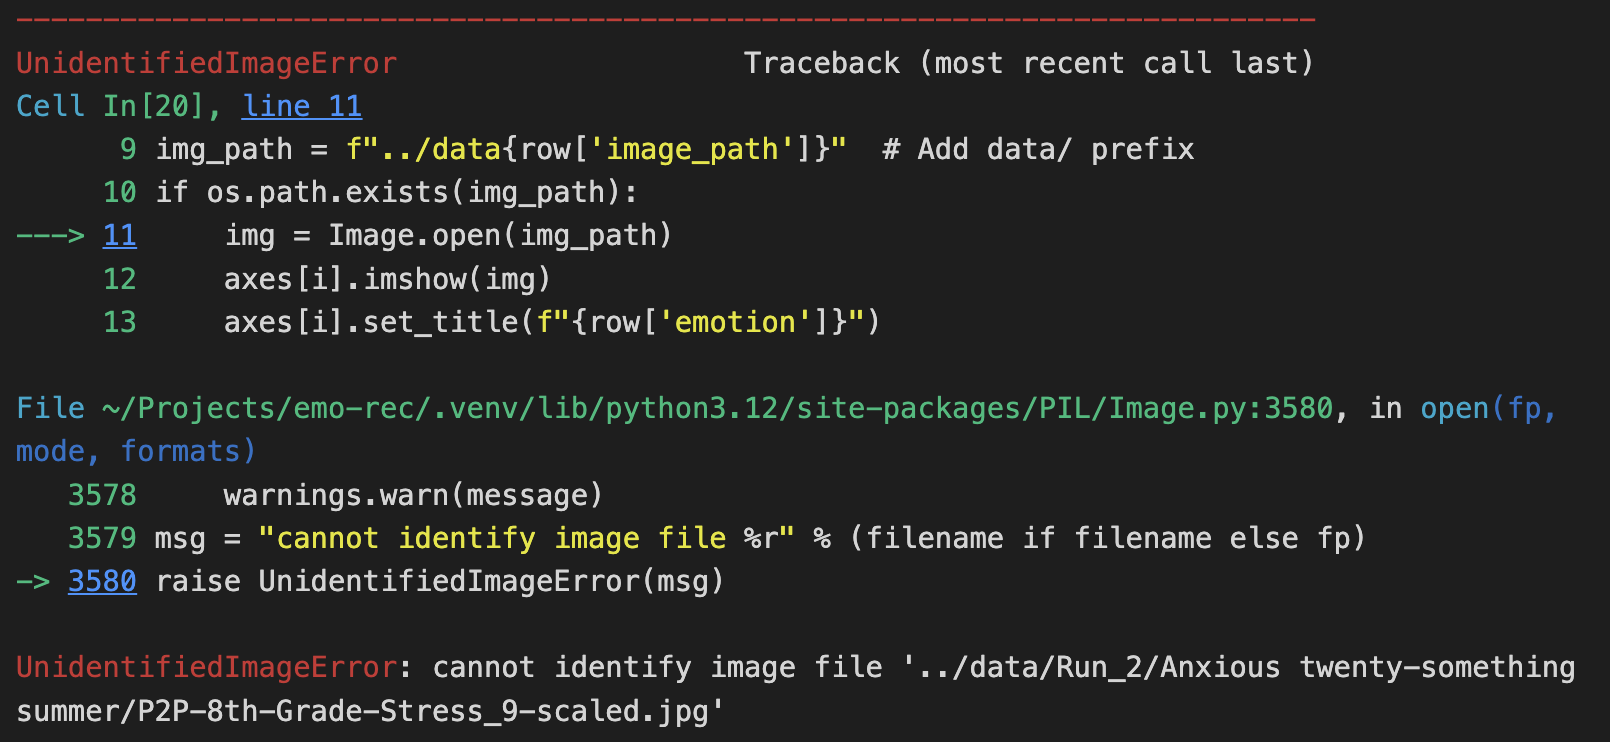. 
